In [ ]:
!pip install hmmlearn

In [ ]:
import yfinance as yf

tickers = ['GOOGL','MSFT']

data = yf.download(tickers, start='2020-01-01', end='2024-01-01')['Close']

[*********************100%***********************]  2 of 2 completed


In [ ]:
import statsmodels.api as sm

# Regress GOOGL ~ MSFT
X = sm.add_constant(data['MSFT'])
model = sm.OLS(data['GOOGL'], X).fit()
data['spread'] = model.resid

In [ ]:
def compute_zscore(spread):
    return (spread - spread.mean()) / spread.std()

data['zscore'] = compute_zscore(data['spread'])

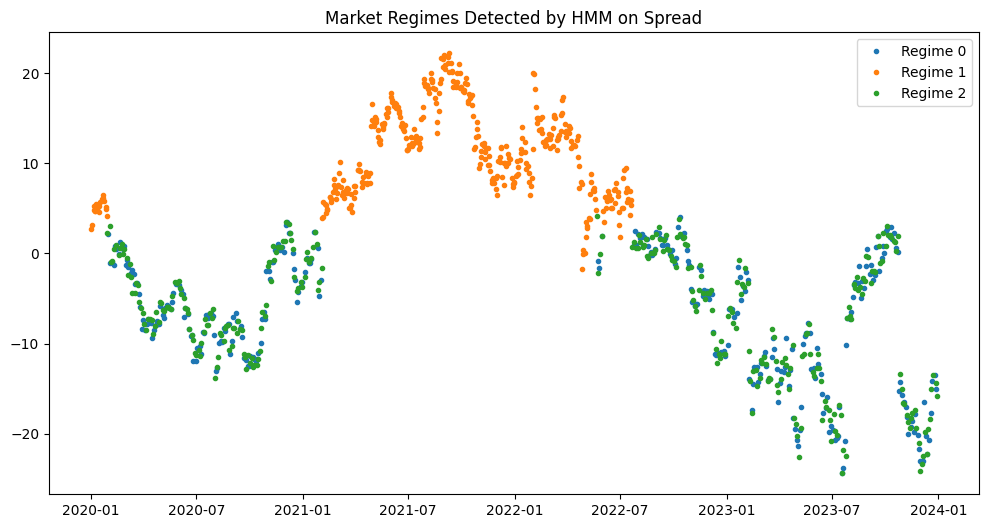

In [ ]:
import matplotlib.pyplot as plt

from hmmlearn.hmm import GaussianHMM

# Fit HMM on spread
hmm_model = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000)
hmm_model.fit(data['spread'].values.reshape(-1, 1))

# Predict hidden states
data['regime'] = hmm_model.predict(data['spread'].values.reshape(-1, 1))

# Plot regimes
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.plot(data['spread'][data['regime'] == i], '.', label=f'Regime {i}')
plt.legend()
plt.title("Market Regimes Detected by HMM on Spread")
plt.show()

In [ ]:
import pandas as pd

# Initialize
positions = pd.DataFrame(index=data.index, columns=['GOOGL', 'MSFT'], data=0)

# Define the mean-reverting regime (change if your model shows different behavior)
mean_reverting_regime = 0

# Long-Short based on z-score and regime
positions.loc[(data['zscore'] < -1) & (data['regime'] == mean_reverting_regime), 'GOOGL'] = 1
positions.loc[(data['zscore'] < -1) & (data['regime'] == mean_reverting_regime), 'MSFT'] = -1

positions.loc[(data['zscore'] > 1) & (data['regime'] == mean_reverting_regime), 'GOOGL'] = -1
positions.loc[(data['zscore'] > 1) & (data['regime'] == mean_reverting_regime), 'MSFT'] = 1

# Exit logic
positions.loc[(abs(data['zscore']) < 0.2), ['GOOGL', 'MSFT']] = 0

positions = positions.fillna(method='ffill')

<ipython-input-22-d3e6cb85aa8f>:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  positions = positions.fillna(method='ffill')


In [ ]:
import numpy as np

returns = np.log(data / data.shift(1)).dropna()

/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


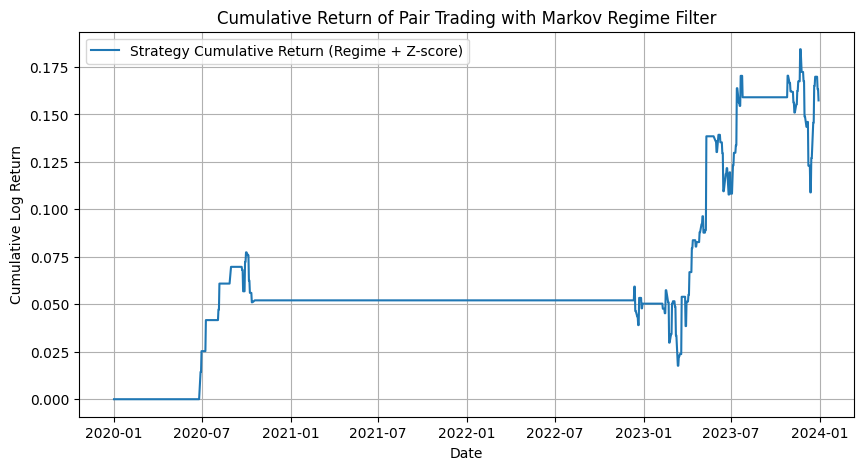

In [ ]:
strategy_returns = (positions.shift(1) * returns[['GOOGL', 'MSFT']]).sum(axis=1)
cumulative_returns = strategy_returns.cumsum()

plt.figure(figsize=(10, 5))
plt.plot(cumulative_returns, label='Strategy Cumulative Return (Regime + Z-score)')
plt.title("Cumulative Return of Pair Trading with Markov Regime Filter")
plt.xlabel("Date")
plt.ylabel("Cumulative Log Return")
plt.legend()
plt.grid()
plt.show()